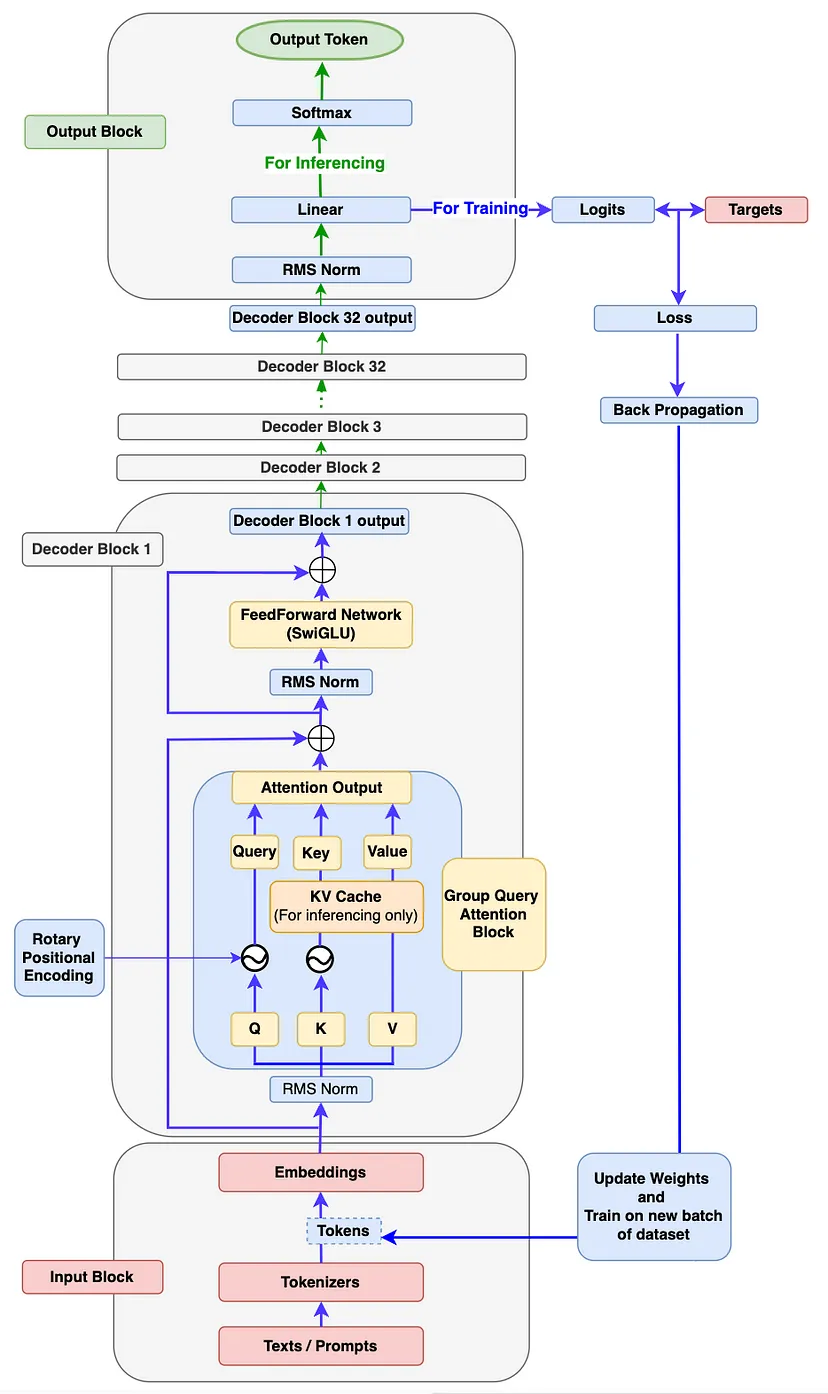

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Callable, Optional, Tuple

texts = [
    "乂煞氣a思齊乂",
    "乂在關渡每過60秒就過了1分鐘。乂",
    "乂打火機比火柴更早被發明出來。乂",
    "乂張開眼睛打噴嚏，這是不可能的事。乂",
    "乂房子很貴不是它的缺點，是我的缺點。乂",
    "乂人睡覺比坐著看電視所消耗的卡路里還多。乂",
    "乂Q:豆腐拍照會變什麼?A:擺YA豆腐。乂",
    "乂Q:為什麼小鳥總是嘰嘰喳喳?A:因為小鳥E人。乂",
    "乂Q:為什麼吸血鬼不喜歡吃辣?A:因為他們喜歡blood。乂",
    "乂Q:為什麼游泳選手總是不小心?A:因為他們總是帽帽濕濕的。乂"
]
vocab = {k: v for k, v in enumerate([""] + list(set("".join(texts))))}

@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = len(vocab)
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5
    rope_theta: float = 32

    max_batch_size: int = 32
    max_seq_len: int = 32

In [2]:
class Tokenizer:
    def __init__(self, vocab: dict):
        self.token2text = vocab
        self.text2token = {v: k for k, v in vocab.items()}

    def encode(self, text: str):
        tokens = [self.text2token[c] for c in text]
        tokens = [0] * (ModelArgs.max_seq_len - len(tokens)) + tokens
        return torch.tensor(tokens)

    def decode(self, tokens: str):
        return "".join([self.token2text[int(t)] for t in tokens])

tokenizer = Tokenizer(vocab)
print(texts[0], "->", tokenizer.encode(texts[0]), "->", tokenizer.decode(tokenizer.encode(texts[0])))

datasets = []
for text in texts:
    for idx in range(len(text)):
        if idx < 3 or idx > len(text) - 1:
            continue
        train = text[:idx]
        label = text[:idx+1]
        datasets.append([tokenizer.encode(train), tokenizer.encode(label)])
for dataset in datasets:
    print("inputs:", dataset[0].shape)
    print(tokenizer.decode(dataset[0]))
    print("target:", dataset[1].shape)
    print(tokenizer.decode(dataset[1]))
    break

class TextDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = datasets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

train_dataloader = torch.utils.data.DataLoader(TextDataset(), batch_size=ModelArgs.max_batch_size, shuffle=True)

乂煞氣a思齊乂 -> tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, 87, 79, 24, 47, 42, 54, 87]) -> 乂煞氣a思齊乂
inputs: torch.Size([32])
乂煞氣
target: torch.Size([32])
乂煞氣a


In [3]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()

class VocabParallelEmbedding(torch.nn.Module):
    def __init__(self,
        num_embeddings: int,
        embedding_dim: int,
        padding_idx: Optional[int] = None,
        max_norm: Optional[float] = None,
        norm_type: float = 2.0,
        scale_grad_by_freq: bool = False,
        sparse: bool = False,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
    ) -> None:
        super(VocabParallelEmbedding, self).__init__()

class ColumnParallelLinear(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        gather_output: bool = True,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
        stride: int = 1,
        keep_master_weight_for_test: bool = False,
    ) -> None:
        super(ColumnParallelLinear, self).__init__()

class RowParallelLinear(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        input_is_parallel: bool = False,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
        stride: int = 1,
        keep_master_weight_for_test: bool = False,
    ):
        super(RowParallelLinear, self).__init__()

class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs, device: str):
        super().__init__()

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    return

class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = VocabParallelEmbedding(
            params.vocab_size, params.dim, init_method=lambda x: x
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            cuda_id = f"cuda:{int(layer_id // (params.n_layers / 4))}"
            self.layers.append(TransformerBlock(layer_id, params, cuda_id))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = ColumnParallelLinear(
            params.dim, params.vocab_size, bias=False, init_method=lambda x: x
        )

        self.freqs_cis = precompute_freqs_cis(
            params.dim // params.n_heads,
            params.max_seq_len * 2,
            params.rope_theta,
        )

Transformer(ModelArgs)

Transformer(
  (tok_embeddings): VocabParallelEmbedding()
  (layers): ModuleList(
    (0-31): 32 x TransformerBlock()
  )
  (norm): RMSNorm()
  (output): ColumnParallelLinear()
)

In [4]:
_MODEL_PARALLEL_GROUP = None

def get_model_parallel_group() -> torch.distributed.ProcessGroup:
    """Get the model parallel group the caller rank belongs to."""
    assert _MODEL_PARALLEL_GROUP is not None, "model parallel group is not initialized"
    return _MODEL_PARALLEL_GROUP

def get_model_parallel_world_size() -> int:
    """Return world size for the model parallel group."""
    return 1
    return torch.distributed.get_world_size(group=get_model_parallel_group())

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, device: str = "cpu"):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        
        self.device = device
        self = self.to(device)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps).to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class VocabParallelEmbedding(torch.nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        padding_idx: Optional[int] = None,
        max_norm: Optional[float] = None,
        norm_type: float = 2.0,
        scale_grad_by_freq: bool = False,
        sparse: bool = False,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
        device: str = "cpu",
    ) -> None:
        super(VocabParallelEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
        self.device = device
        self = self.to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.embedding(x)

class ColumnParallelLinear(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        gather_output: bool = True,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
        stride: int = 1,
        keep_master_weight_for_test: bool = False,
        device: str = "cpu",
    ) -> None:
        super(ColumnParallelLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.device = device
        self = self.to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.linear(x)

class RowParallelLinear(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        input_is_parallel: bool = False,
        init_method: Callable[[torch.Tensor], torch.Tensor] = lambda x: x,
        stride: int = 1,
        keep_master_weight_for_test: bool = False,
        device: str = "cpu",
    ):
        super(RowParallelLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.device = device
        self = self.to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.linear(x)

class Attention(nn.Module):
    def __init__(self, args: ModelArgs, device: str):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        model_parallel_size = get_model_parallel_world_size()
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads

        self.wq = ColumnParallelLinear(
            args.dim,
            args.n_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
            device=device,
        )
        self.wk = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
            device=device,
        )
        self.wv = ColumnParallelLinear(
            args.dim,
            self.n_kv_heads * self.head_dim,
            bias=False,
            gather_output=False,
            init_method=lambda x: x,
            device=device,
        )
        self.wo = RowParallelLinear(
            args.n_heads * self.head_dim,
            args.dim,
            bias=False,
            input_is_parallel=True,
            init_method=lambda x: x,
            device=device,
        )

        self.cache_k = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).to(device)
        self.cache_v = torch.zeros(
            (
                args.max_batch_size,
                args.max_seq_len,
                self.n_local_kv_heads,
                self.head_dim,
            )
        ).to(device)
        
        self.device = device
        self = self.to(device)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        x = x.to(self.device)
        freqs_cis = freqs_cis.to(self.device)
        mask = mask.to(self.device)
        
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)
        
        self.cache_k = self.cache_k.to(xq)
        self.cache_v = self.cache_v.to(xq)

        self.cache_k[:bsz, start_pos : start_pos + seqlen] = xk.detach().clone()
        self.cache_v[:bsz, start_pos : start_pos + seqlen] = xv.detach().clone()
    
        keys = self.cache_k[:bsz, : start_pos + seqlen]
        values = self.cache_v[:bsz, : start_pos + seqlen]

        # repeat k/v heads if n_kv_heads < n_heads
        keys = repeat_kv(
            keys, self.n_rep
        )  # (bs, cache_len + seqlen, n_local_heads, head_dim)
        values = repeat_kv(
            values, self.n_rep
        )  # (bs, cache_len + seqlen, n_local_heads, head_dim)

        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        keys = keys.transpose(1, 2)  # (bs, n_local_heads, cache_len + seqlen, head_dim)
        values = values.transpose(
            1, 2
        )  # (bs, n_local_heads, cache_len + seqlen, head_dim)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask  # (bs, n_local_heads, seqlen, cache_len + seqlen)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)  # (bs, n_local_heads, seqlen, head_dim)
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)

class FeedForward(nn.Module):
    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        multiple_of: int,
        ffn_dim_multiplier: Optional[float],
        device: str
    ):
        super().__init__()
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if ffn_dim_multiplier is not None:
            hidden_dim = int(ffn_dim_multiplier * hidden_dim)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x, device=device
        )
        self.w2 = RowParallelLinear(
            hidden_dim, dim, bias=False, input_is_parallel=True, init_method=lambda x: x, device=device
        )
        self.w3 = ColumnParallelLinear(
            dim, hidden_dim, bias=False, gather_output=False, init_method=lambda x: x, device=device
        )
        
        self.device = device
        self = self.to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs, device: str):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args, device)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=4 * args.dim,
            multiple_of=args.multiple_of,
            ffn_dim_multiplier=args.ffn_dim_multiplier,
            device=device,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps, device=device)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps, device=device)
        
        self.device = device
        self = self.to(device)

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_cis: torch.Tensor,
        mask: Optional[torch.Tensor],
    ):
        x = x.to(self.device)
        freqs_cis = freqs_cis.to(self.device)
        mask = mask.to(self.device)
        
        h = x + self.attention(self.attention_norm(x), start_pos, freqs_cis, mask)
        out = h + self.feed_forward(self.ffn_norm(h))
        return out

class Transformer(nn.Module):
    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = VocabParallelEmbedding(
            params.vocab_size, params.dim, init_method=lambda x: x
        )

        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            device = f"cuda:{int(layer_id // (params.n_layers / torch.cuda.device_count()))}"
            self.layers.append(TransformerBlock(layer_id, params, device))

        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = ColumnParallelLinear(
            params.dim, params.vocab_size, bias=False, init_method=lambda x: x
        )

        self.freqs_cis = precompute_freqs_cis(
            params.dim // params.n_heads,
            params.max_seq_len * 2,
            params.rope_theta,
        )

    # @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int):
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        self.freqs_cis = self.freqs_cis.to(h.device)
        freqs_cis = self.freqs_cis[start_pos : start_pos + seqlen]

        mask = None
        if seqlen > 1:
            mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack(
                [torch.zeros((seqlen, start_pos), device=tokens.device), mask]
            ).type_as(h)

        for layer in self.layers:
            h = layer(h, start_pos, freqs_cis, mask)
        h = self.norm(h)
        output = self.output(h).float()
        return output

model = Transformer(ModelArgs)
model

Transformer(
  (tok_embeddings): VocabParallelEmbedding(
    (embedding): Embedding(113, 4096)
  )
  (layers): ModuleList(
    (0-31): 32 x TransformerBlock(
      (attention): Attention(
        (wq): ColumnParallelLinear(
          (linear): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (wk): ColumnParallelLinear(
          (linear): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (wv): ColumnParallelLinear(
          (linear): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (wo): RowParallelLinear(
          (linear): Linear(in_features=4096, out_features=4096, bias=False)
        )
      )
      (feed_forward): FeedForward(
        (w1): ColumnParallelLinear(
          (linear): Linear(in_features=4096, out_features=11008, bias=False)
        )
        (w2): RowParallelLinear(
          (linear): Linear(in_features=11008, out_features=4096, bias=False)
        )
        (w3): ColumnParallelLinear(
     

In [5]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    for i, data in enumerate(train_dataloader):
        optim.zero_grad()
        model.train(True)
        inputs, target = data
        output = model(inputs, 0)
        logits = output.view(-1, ModelArgs.vocab_size)
        target = target.view(-1).to(logits.device)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optim.step()
        train_loss = train_loss + loss.data
        model.eval()
    train_loss = train_loss / len(train_dataloader)
    print("Epoch {: 5d}/{}\t- loss: {:.4f}".format(epoch + 1, epochs, train_loss))

Epoch     1/20	- loss: 2.6333
Epoch     2/20	- loss: 0.8283
Epoch     3/20	- loss: 0.4445
Epoch     4/20	- loss: 0.3094
Epoch     5/20	- loss: 0.2546
Epoch     6/20	- loss: 0.2393
Epoch     7/20	- loss: 0.2198
Epoch     8/20	- loss: 0.2166
Epoch     9/20	- loss: 0.2191
Epoch    10/20	- loss: 0.2149
Epoch    11/20	- loss: 0.2103
Epoch    12/20	- loss: 0.2034
Epoch    13/20	- loss: 0.2003
Epoch    14/20	- loss: 0.1983
Epoch    15/20	- loss: 0.1951
Epoch    16/20	- loss: 0.1941
Epoch    17/20	- loss: 0.1949
Epoch    18/20	- loss: 0.1942
Epoch    19/20	- loss: 0.1941
Epoch    20/20	- loss: 0.1954


In [6]:
prompts = [
    "乂煞氣",
    "乂在關渡",
    "乂打火機比",
    "乂張開眼睛打",
    "乂房子很貴不是",
    "乂人睡覺比坐著看",
    "乂Q:豆腐拍照會變什",
    "乂Q:為什麼小鳥總是嘰",
    "乂Q:為什麼吸血鬼不喜歡",
    "乂Q:為什麼游泳選手總是不"
]
model.eval()
for prompt in prompts:
    while prompt[-1] != "乂":
        if len(prompt) > ModelArgs.max_seq_len - 2:
            break
        tokens = tokenizer.encode(prompt)
        tokens = tokens[None, :]
        output = model(tokens, 0)
        nexttk = [int(torch.argmax(output[:, -1], dim=-1))]
        nextwd = tokenizer.decode(nexttk)
        prompt = prompt + nextwd
    print(prompt)

乂煞氣a思齊乂
乂在關渡每過60秒就過了1分鐘。乂
乂打火機比火柴更早被發明出來。乂
乂張開眼睛打噴嚏，這是不可能的事。乂
乂房子很貴不是它的缺點，是我的缺點。乂
乂人睡覺比坐著看電視所消耗的卡路里還多。乂
乂Q:豆腐拍照會變什麼?A:擺YA豆腐。乂
乂Q:為什麼小鳥總是嘰嘰喳喳?A:因為小鳥E人。乂
乂Q:為什麼吸血鬼不喜歡吃辣?A:因為他們喜歡blood。乂
乂Q:為什麼游泳選手總是不小心?A:因為他們總是帽帽濕濕的。乂


## Reference

[meta-llama/llama3](https://github.com/meta-llama/llama3)

[Build Your Own Llama 3 Architecture from Scratch Using PyTorch](https://pub.towardsai.net/build-your-own-llama-3-architecture-from-scratch-using-pytorch-2ce1ecaa901c)